### Imports

In [1]:
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
import tensorflow.keras.applications as kapp
import tensorflow.keras.backend as K
import tensorflow as tf
from scipy import special, signal
from PIL import Image
import matplotlib.pyplot as plt
import numpy.random as npr
import pickle as pkl
import numpy as np
import os, random, time, cv2, multiprocessing, scipy, warnings, itertools
warnings.filterwarnings("ignore") # make np shut up about sinc div 0 issue
print(tf.__version__)

2.4.1


### TPU Init

In [2]:
tpuOn = True

try:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

    # instantiate a distribution strategy
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    policy = mixed_precision.Policy('mixed_bfloat16')
    mixed_precision.set_global_policy(policy)
except:
    tpuOn = False

### Hyperparameters

In [3]:
train_mode = 'psnr'
pretrained_net = False
pretrained_gan = False

PARAM_MULT = 0 # determines the width and depth of the network
DEPTH =         1
CARDINALITY =   1
WIDTH =         1
USE_SE =        False
SE_FACTOR =     1.0
USE_TF =        True
NHEADS =        4
TF_NBLOCKS =    16
ALPHA, BETA =   2 ** 0.5, 2 ** 0.25 # efficientnet type beat, it happens that beta^2 is roughly equal to alpha in efficientnet
CNN_NBLOCKS =   int((DEPTH*8) * ALPHA**PARAM_MULT)
CNN_NF =        8 * int((WIDTH*64) * BETA**PARAM_MULT / 8) # round to nearest 8 channels
TF_NF =         CNN_NF
NF =            CNN_NF

BATCH_SIZE = 256 if train_mode == 'psnr' else 64
BATCH_SIZE = BATCH_SIZE // 8 if not tpuOn else BATCH_SIZE
NET_STEPS = 1000000 * 48 / BATCH_SIZE
STEPS_PER_EPOCH = 125 if tpuOn else 1000
GAN_STEPS = 400000 * 48 / BATCH_SIZE
LR_RES = 64
HR_RES = 256
N_CORES = multiprocessing.cpu_count()
EPS = 1e-8

### Misc Funcs

In [4]:
def toNp(*args):
    ret = []
    for arg in args:
        try:
            arg = arg.values if tpuOn else arg
            arg = tf.reduce_mean(arg).numpy()
            ret.append(arg)
        except Exception as e:
            print(e)
    return ret

r4 = lambda number: round(number, 4)

def save_models(askInp=True):
    if askInp:
        input()
    
    try:
        os.mkdir('/kaggle/working/scale{}'.format(PARAM_MULT))
    except:
        pass
    
    os.chdir('/kaggle/working/scale{}'.format(PARAM_MULT))
    gen.save_weights('genWeights.h5')
    disc.save_weights('discWeights.h5')
    
    os.chdir('/kaggle/working')
    print('Zipping...')
    try:
        !zip -1 -r -qq heavySR.zip scale*
    except:
        os.system('zip -1 -r -qq heavySR.zip scale*')
    print('Done zipping.')

### Display Func

In [5]:
def display():
    cols = 5
    fig, axes = plt.subplots(nrows=3, ncols=cols, figsize=(20, 10))
    batch_num = int(np.ceil(cols / N_CORES)) * N_CORES
    lr, hr = examine_batch(batch_num)
    preds = gen(lr)
    
    for c in range(cols):
        axes[0][c].imshow(lr[c] / 2 + 0.5)
        axes[1][c].imshow(preds[c] / 2 + 0.5)
        axes[2][c].imshow(hr[c] / 2 + 0.5)
        
    loss = mae(hr, preds).numpy()
    print('MAE:', r4(loss))
    plt.show()

### Augmentation

JPEG utils

In [6]:
def quality_to_factor(quality):
    if quality < 50:
        quality = 5000. / quality
    else:
        quality = 200. - quality*2
    return quality / 100.

y_table = np.array(
    [[16, 11, 10, 16, 24, 40, 51, 61], [12, 12, 14, 19, 26, 58, 60, 55], [14, 13, 16, 24, 40, 57, 69, 56],
     [14, 17, 22, 29, 51, 87, 80, 62], [18, 22, 37, 56, 68, 109, 103, 77], [24, 35, 55, 64, 81, 104, 113, 92],
     [49, 64, 78, 87, 103, 121, 120, 101], [72, 92, 95, 98, 112, 100, 103, 99]],
    dtype=np.float32).T

c_table = np.empty((8, 8), dtype=np.float32)
c_table.fill(99)
c_table[:4, :4] = np.array([[17, 18, 24, 47], [18, 21, 26, 66], [24, 26, 56, 99], [47, 66, 99, 99]]).T

# compression variables
rgb_to_ycbcr_matrix = np.array(
    [[0.299, 0.587, 0.114], [-0.168736, -0.331264, 0.5],
     [0.5, -0.418688, -0.081312]], dtype=np.float32).T
rgb_to_ycbcr_shift = np.array([0., 128., 128.], dtype=np.float32)

dct_tensor = np.zeros((8, 8, 8, 8), dtype=np.float32)
for x, y, u, v in itertools.product(range(8), repeat=4):
    dct_tensor[x, y, u, v] = np.cos((2 * x + 1) * u * np.pi / 16) * np.cos(
        (2 * y + 1) * v * np.pi / 16)
dct_alpha = np.array([1. / np.sqrt(2)] + [1] * 7).astype(np.float32)
dct_scale = np.outer(dct_alpha, dct_alpha) * 0.25

# decompression variables
idct_alpha = np.array([1. / np.sqrt(2)] + [1] * 7).astype(np.float32)
idct_alpha = np.outer(idct_alpha, idct_alpha)
idct_tensor = np.zeros((8, 8, 8, 8), dtype=np.float32)
for x, y, u, v in itertools.product(range(8), repeat=4):
    idct_tensor[x, y, u, v] = np.cos((2 * u + 1) * x * np.pi / 16) * np.cos(
        (2 * v + 1) * y * np.pi / 16)
    
ycbcr_to_rgb_matrix = np.array(
    [[1., 0., 1.402], [1, -0.344136, -0.714136], [1, 1.772, 0]],
    dtype=np.float32).T
ycbcr_to_rgb_shift = np.array([0, -128., -128.], dtype=np.float32)

blur_51 = cv2.getGaussianKernel(51, 0)
blur_51 = tf.constant(np.outer(blur_51, blur_51).astype(np.float32))
blur_51 = tf.reshape(blur_51, (*blur_51.shape, 1, 1))
blur_51 = tf.tile(blur_51, (1, 1, 3, 1))

JPEG Compression (https://github.com/mlomnitz/DiffJPEG/blob/master/modules/compression.py)

In [7]:
def rgb_to_ycbcr_jpeg(image):
    result = np.tensordot(image, rgb_to_ycbcr_matrix, axes=1) + rgb_to_ycbcr_shift
    return result

def chroma_subsampling(image):
    def avg_pool(image):
        H, W = image.shape
        ret_y = H // 2
        ret_x = W // 2

        new_shape = (ret_y, 2, ret_x, 2)
        reshaped = image.reshape(new_shape)
        
        ret = np.nanmean(reshaped, axis=(1, 3))
        
        return ret
    
    cb = avg_pool(image[:, :, 1])
    cr = avg_pool(image[:, :, 2])
    return image[:, :, 0], cb, cr

def block_splitting(image):
    k = 8
    height, width = image.shape[:2]
    image_reshaped = image.reshape(height // k, k, -1, k)
    image_transposed = np.transpose(image_reshaped, (0, 2, 1, 3))
    return image_transposed.reshape(-1, k, k)

def dct_8x8(image):
    image = image - 128
    result = dct_scale * np.tensordot(image, dct_tensor, axes=2)
    return result

def y_quantize(image, factor=1):
    image = image / (y_table * factor).astype(np.float32)
    image = np.round(image)
    return image

def c_quantize(image, factor=1):
    image = image / (c_table * factor).astype(np.float32)
    image = np.round(image)
    return image

def compress_jpeg(image, factor=1):
    def l1(img):
        img = rgb_to_ycbcr_jpeg(img)
        img = chroma_subsampling(img)
        return img
    
    def l2(img):
        img = block_splitting(img)
        img = dct_8x8(img)
        return img
        
    y, cb, cr = l1(image)
    components = {'y': y, 'cb': cb, 'cr': cr}
    for k in components.keys():
        comp = l2(components[k])
        if k in ('cb', 'cr'):
            comp = c_quantize(comp, factor=factor)
        else:
            comp = y_quantize(comp, factor=factor)

        components[k] = comp

    return components['y'], components['cb'], components['cr']

JPEG Decompression (https://github.com/mlomnitz/DiffJPEG/blob/master/modules/decompression.py)

In [8]:
from numba import njit

@njit
def y_dequantize(image, factor=1):
    return image * (y_table * factor).astype(np.float32)

@njit
def c_dequantize(image, factor=1):
    return image * (c_table * factor).astype(np.float32)

def idct_8x8(image):
    image = image * idct_alpha
    result = 0.25 * np.tensordot(image, idct_tensor, axes=2) + 128
    return result

def block_merging(patches, height, width):
    k = 8
    image_reshaped = patches.reshape(height//k, width//k, k, k)
    image_transposed = np.transpose(image_reshaped, (0, 2, 1, 3))
    return image_transposed.reshape(height, width)

def chroma_upsampling(y, cb, cr):
    def repeat(x, k=2):
        height, width = x.shape[:2]
        x = np.repeat(x, k, axis=0)
        x = np.repeat(x, k, axis=1)
        return x

    cb = repeat(cb)
    cr = repeat(cr)

    return np.concatenate([y[:, :, np.newaxis], cb[:, :, np.newaxis], cr[:, :, np.newaxis]], axis=2)

def ycbcr_to_rgb_jpeg(image):
    result = np.tensordot(image + ycbcr_to_rgb_shift, ycbcr_to_rgb_matrix, axes=1)
    return result

def decompress_jpeg(y, cb, cr, height, width, rounding=np.round, factor=1):
    components = {'y': y, 'cb': cb, 'cr': cr}
    for k in components.keys():
        if k in ('cb', 'cr'):
            comp = c_dequantize(components[k], factor=factor)
            h, w = int(height/2), int(width/2)           
        else:
            comp = y_dequantize(components[k], factor=factor)
            h, w = height, width
        
        comp = idct_8x8(comp)
        components[k] = block_merging(comp, h, w)
    image = chroma_upsampling(components['y'], components['cb'], components['cr'])
    image = ycbcr_to_rgb_jpeg(image)

    return image 

Augmentation helper funcs

In [9]:
# sinc kernel
def circular_lowpass_kernel(omega_c, N):  # omega = cutoff frequency in radians (pi is max), N = horizontal size of the kernel, also its vertical size, must be odd.
    kernel = np.fromfunction(lambda x, y: omega_c*special.j1(omega_c*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2))/(2*np.pi*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2)), [N, N]) 
    kernel[(N - 1) // 2, (N - 1) // 2] = omega_c ** 2 / (4 * np.pi)
    kernel /= np.sum(kernel)
    return kernel

def apply_sinc(img, p, ksize, min_omega_c=5):
    _H, _W, C = img.shape
    if npr.uniform() < p:
        if ksize < 13:
            omega_c = npr.uniform(np.pi / 3, np.pi)
        else:
            omega_c = npr.uniform(np.pi / min_omega_c, np.pi)
        sinc_kernel = circular_lowpass_kernel(omega_c, ksize).astype(np.float32)
        img = cv2.filter2D(img, -1, sinc_kernel)
        
    return img

# stolen from real-esrgan github (Real-ESRGAN/realesrgan/models/realesrgan_model.py)
def generate_poisson_noise(img, scale=1.0, gray_noise=False):
    if gray_noise:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # round and clip image for counting vals correctly
    img = np.clip(img, 0, 255) / 255.
    vals = len(np.unique(img))
    vals = 2**np.ceil(np.log2(vals))
    out = np.float32(npr.poisson(img * vals) / float(vals))
    noise = out - img
    if gray_noise:
        noise = noise[:, :, np.newaxis]
    return noise * scale

@tf.function
def usm(batch):
    def b51(x):
        pad_x = tf.pad(x, [[0, 0], [25, 25], [25, 25], [0, 0]], mode='REFLECT')
        blurred = tf.nn.depthwise_conv2d(pad_x, blur_51, strides=[1,1,1,1], padding='VALID')
        return blurred
    
    batch = batch / 2 + 0.5 # [-1, 1] -> [-0.5, 0.5] -> [0, 1]
    blurred = b51(batch)
    res = batch - blurred
    mask = tf.nn.relu(tf.sign(tf.math.abs(res) * 255 - 10.))
    soft_mask = b51(mask)

    K = batch + 0.5 * res
    K = tf.clip_by_value(K, 0, 1)
    K = soft_mask * K + (1 - soft_mask) * batch
    return K * 2. - 1.

Aug Pipeline (only one order)

In [10]:
def aug(img,
        p_skip_blur=0.0, resize_gain=HR_RES,
        stdev_range=[0.2, 3],
        resize_probs=[0.2, 0.7, 0.1], resize_range=[0.3, 1.25],
        gaussian_noise_range=[1, 30], poisson_noise_range=[0.05, 3]):
    
    # blur
    if npr.uniform() > p_skip_blur:
        ksize = 2 * npr.randint(0, 7) + 7
        if npr.uniform() < 0.9:
            stdev = npr.uniform(stdev_range[0], stdev_range[1])
            img = cv2.GaussianBlur(img, (ksize, ksize), stdev, borderType=cv2.BORDER_REFLECT)
        else:
            img = apply_sinc(img, 1.0, ksize)
     
    # resize
    interp_methods = [cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA]
    resize_methods = [
        lambda: npr.uniform(1, resize_range[1]), # upscale
        lambda: npr.uniform(resize_range[0], 1), # downscale
        lambda: 1 # no rescale
    ]
    
    resize_factor = npr.choice(resize_methods, p=resize_probs)()
    interp_method = npr.choice(interp_methods)
    new_res = int(resize_gain * resize_factor)
    img = cv2.resize(img, (new_res, new_res), interpolation=interp_method)
    
    # noise
    use_gray_noise = np.random.uniform() < 0.4
    if use_gray_noise:
        if np.random.uniform() < 0.5:
            g_std = npr.uniform(gaussian_noise_range[0], gaussian_noise_range[1])
            noise = npr.randn(*img.shape[:-1])[:, :, np.newaxis] * g_std
        else:
            p_scale = npr.uniform(poisson_noise_range[0], poisson_noise_range[1]) * 255
            noise = generate_poisson_noise(img, p_scale, gray_noise=True)
    else:
        if np.random.uniform() < 0.5:
            g_std = npr.uniform(gaussian_noise_range[0], gaussian_noise_range[1])
            noise = npr.randn(*img.shape) * g_std
        else:
            p_scale = npr.uniform(poisson_noise_range[0], poisson_noise_range[1]) * 255
            noise = generate_poisson_noise(img, p_scale, gray_noise=False)
    img += noise.astype(np.float32)
    
    # jpg degradation outside of this function
    
    return img

Second order aug func

In [11]:
def full_lr_aug(img):
    # apply a jpeg degradation to an image with a random compression level
    def rand_jpeg(img):
        H, W, C = img.shape
        h_pad, w_pad = 0, 0
        # use 16 since dct requires an image divisible by 8x8 and chroma subsampling downscales imgs by 2
        if H % 16 != 0:
            h_pad = 16 - H % 16
        if W % 16 != 0:
            w_pad = 16 - W % 16
        img = np.clip(img, 0, 255)
        img = np.pad(img, ((0, h_pad), (0, w_pad), (0, 0)))
        
        quality = npr.randint(30, 95)
        factor = quality_to_factor(quality)
        y, cb, cr = compress_jpeg(img, factor=factor)
        img = decompress_jpeg(y, cb, cr, H+h_pad, W+w_pad, factor=factor)
        img = img[:H, :W]
        return img
    
    # resize to (LR_RES, LR_RES), then sinc kernel with p = 0.8
    def resize_sinc(img):
        interp_methods = [cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA]
        interp_method = npr.choice(interp_methods)
        img = cv2.resize(img, (LR_RES, LR_RES), interpolation=interp_method)
        ksize = 2 * npr.randint(0, 7) + 7
        img = apply_sinc(img, 0.8, ksize, min_omega_c=3)
        return img
        
    img = img.astype(np.float32)
    
    # first order degradation
    img = aug(img,
             p_skip_blur=0.0, resize_gain=HR_RES,
             stdev_range=[0.2, 3],
             resize_probs=[0.2, 0.7, 0.1], resize_range=[0.15, 1.5],
             gaussian_noise_range=[1, 30], poisson_noise_range=[0.05, 3])
    
    # first jpeg degradation
    img = rand_jpeg(img)
    
    # second order degradation
    img = aug(img,
              p_skip_blur=0.2, resize_gain=LR_RES,
              stdev_range=[0.2, 1.5],
              resize_probs=[0.3, 0.4, 0.3], resize_range=[0.3, 1.2],
              gaussian_noise_range=[1, 25], poisson_noise_range=[0.05, 2.5])
    
    # final touches - jpeg, then resize+sinc OR resize+sinc, then jpeg
    if npr.uniform(()) < 0.5:
        img = rand_jpeg(img)
        img = resize_sinc(img)
    else:
        img = resize_sinc(img)
        img = rand_jpeg(img)
    img = np.clip(img, 0, 255)
    
    return img

### Batch Load Func

Legacy

In [12]:
def listdir_abs_path(folder):
    ret = []
    ff = os.listdir(folder)
    for fname in ff:
        ret.append(os.path.join(folder, fname))
        
    return ret

dataset_path = '/kaggle/input/df2k-ost/train'
df2k_filenames = listdir_abs_path(os.path.join(dataset_path, 'Flickr2K')) + listdir_abs_path(os.path.join(dataset_path, 'DIV2K/DIV2K_train_HR'))
ost_filenames = listdir_abs_path(os.path.join(dataset_path, 'OST'))
use_df2k = True # alternate batches between using DF2K and OST

def sample_from_img(filenames, procnum, lr_return_dict, hr_return_dict, samples_per_img, n_rot_samples):
    lr = np.empty((len(filenames) * samples_per_img * n_rot_samples, LR_RES, LR_RES, 3), dtype=np.float32)
    hr = np.empty((len(filenames) * samples_per_img * n_rot_samples, HR_RES, HR_RES, 3), dtype=np.float32)
    
    for idx, filename in enumerate(filenames):
        img = Image.open(os.path.join(dataset_path, filename))
        img_arr = np.array(img)
        for samp_idx in range(samples_per_img):
            # crop image
            if img_arr.shape[1] - HR_RES == 0:
                crop_x = 0
            else:
                crop_x = npr.randint(0, img_arr.shape[1] - HR_RES)

            if img_arr.shape[0] - HR_RES == 0:
                crop_y = 0
            else:
                crop_y = npr.randint(0, img_arr.shape[0] - HR_RES)

            cropped_img = img_arr[crop_y:crop_y+HR_RES, crop_x:crop_x+HR_RES]
            
            # 2nd order aug pipeline
            lr_img = full_lr_aug(cropped_img)
            
            for rot_idx in range(n_rot_samples):
                # rotate and flip the HR and LR augmented images multiple times to reduce time spent on degradation
                if npr.uniform() < 0.5: # flip
                    cropped_img = cropped_img[:, ::-1, :]
                    lr_img = lr_img[:, ::-1, :]
                rotation = npr.randint(0, 4)
                cropped_img = np.rot90(cropped_img, rotation)
                lr_img = np.rot90(lr_img, rotation)
            
                # put the LR and HR image into a return array
                lr[n_rot_samples * (samples_per_img * (idx) + samp_idx) + rot_idx] = lr_img
                hr[n_rot_samples * (samples_per_img * (idx) + samp_idx) + rot_idx] = cropped_img
    
    lr_return_dict[procnum] = lr
    hr_return_dict[procnum] = hr
    return lr

def load_batch(num_imgs=BATCH_SIZE, samples_per_img=None, n_rot_samples=4):
    global use_df2k
    
    # if user specify samples_per_img, they usually want to view the images instead of loading it for the NN, so load OST images for extra speed
    if samples_per_img != None:
        filenames = random.sample(ost_filenames, num_imgs // samples_per_img // n_rot_samples)
    else:
        if use_df2k:
            # arbitrary value and represents the amount of times that each image from disk is degraded (important since it's computationally expensive)
            # bigger number = more variety but slower
            num_degradations_per_img = 4
            
            # dividing by n_rot_samples here because the total number of sampled images from an image from disk is multiplied by n_rot_samples
            samples_per_img = num_imgs // n_rot_samples // num_degradations_per_img
            filenames = random.sample(df2k_filenames, num_imgs // samples_per_img // n_rot_samples) # len(filenames) * samples_per_img * n_rot_samples = num_imgs
        else: # if using OST dataset, the images are too small to sample multiple HR crops of them without significant overlap
            samples_per_img = 1
            filenames = random.sample(ost_filenames, num_imgs // samples_per_img // n_rot_samples)
    
    use_df2k = not use_df2k
        
    assert num_imgs % samples_per_img == 0
    lr = np.empty((num_imgs, LR_RES, LR_RES, 3), dtype=np.float32)
    hr = np.empty((num_imgs, HR_RES, HR_RES, 3), dtype=np.float32)
    
    nprocs = N_CORES
    assert len(filenames) >= nprocs and len(filenames) % nprocs == 0 # make sure images are being loaded in parallel (you want 4 procs to work on >=4 images in total)
    
    imgs_per_proc = len(filenames) // nprocs
    manager = multiprocessing.Manager()
    lr_return_dict = manager.dict()
    hr_return_dict = manager.dict()
    jobs = []
    for procnum in range(nprocs):
        s_i = procnum * imgs_per_proc
        e_i = (procnum + 1) * imgs_per_proc
        p = multiprocessing.Process(
            target=sample_from_img,
            args=(filenames[s_i:e_i], procnum,
                  lr_return_dict, hr_return_dict, samples_per_img, n_rot_samples))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
    for procnum in range(nprocs):
        s_i = procnum * imgs_per_proc * samples_per_img * n_rot_samples
        e_i = (procnum + 1) * imgs_per_proc * samples_per_img * n_rot_samples
        lr[s_i:e_i] = lr_return_dict[procnum]
        hr[s_i:e_i] = hr_return_dict[procnum]
        
    lr = lr / 127.5 - 1
    hr = hr / 127.5 - 1
    
    return lr, hr

Revised

In [13]:
import signal

def listdir_abs_path(folder):
    ret = []
    ff = os.listdir(folder)
    for fname in ff:
        ret.append(os.path.join(folder, fname))
        
    return ret

dataset_path = '/kaggle/input/df2k-ost/train'
df2k_filenames = listdir_abs_path(os.path.join(dataset_path, 'Flickr2K')) + listdir_abs_path(os.path.join(dataset_path, 'DIV2K/DIV2K_train_HR'))
ost_filenames = listdir_abs_path(os.path.join(dataset_path, 'OST'))

valid_dataset_path = '/kaggle/input/df2k-ost/test'
valid_ost_filenames = listdir_abs_path(os.path.join(valid_dataset_path, 'OutdoorSceneTest300'))
use_df2k = True # alternate batches between using DF2K and OST

def get_cropped_imgs(filenames, procnum, return_dict, crops_per_img):
    signal.signal(signal.SIGINT, signal.SIG_IGN)
    ret = np.empty((len(filenames) * crops_per_img, HR_RES, HR_RES, 3), dtype=np.float32)
    
    for idx, filename in enumerate(filenames):
        img = Image.open(os.path.join(dataset_path, filename))
        img_arr = np.array(img)
        for samp_idx in range(crops_per_img):
            # crop image
            if img_arr.shape[1] - HR_RES == 0:
                crop_x = 0
            else:
                crop_x = npr.randint(0, img_arr.shape[1] - HR_RES)

            if img_arr.shape[0] - HR_RES == 0:
                crop_y = 0
            else:
                crop_y = npr.randint(0, img_arr.shape[0] - HR_RES)

            cropped_img = img_arr[crop_y:crop_y+HR_RES, crop_x:crop_x+HR_RES]
            ret[idx * crops_per_img + samp_idx] = cropped_img
    
    return_dict[procnum] = ret

def aug_batch(batch, n_rot_samples):
    lr = np.empty((batch.shape[0] * n_rot_samples, LR_RES, LR_RES, 3), dtype=np.float32)
    hr = np.empty((batch.shape[0] * n_rot_samples * n_rot_samples, HR_RES, HR_RES, 3), dtype=np.float32)
    
    for idx, img in enumerate(batch):
        # 2nd order aug pipeline
        #lr_img = full_lr_aug(img)
        lr_img = cv2.resize(img, (LR_RES, LR_RES), interpolation=cv2.INTER_CUBIC)
        lr_img = np.clip(lr_img, 0, 255)

        for rot_idx in range(n_rot_samples):
            # rotate and flip the HR and LR augmented images multiple times to reduce time spent on degradation
            if npr.uniform() < 0.5: # flip
                img = img[:, ::-1, :]
                lr_img = lr_img[:, ::-1, :]
            rotation = npr.randint(0, 4)
            img = np.rot90(img, rotation)
            lr_img = np.rot90(lr_img, rotation)

            # put the LR and HR image into a return array
            lr[n_rot_samples * idx + rot_idx] = lr_img / 127.5 -1
            hr[n_rot_samples * idx + rot_idx] = img / 127.5 -1
    
    return lr, hr

def get_unaug_batch(filenames, crops_per_img):
    num_imgs = len(filenames)
    hr = np.empty((num_imgs * crops_per_img, HR_RES, HR_RES, 3), dtype=np.float32)
    
    nprocs = N_CORES
    assert num_imgs >= nprocs and num_imgs % nprocs == 0 # make sure images are being loaded in parallel (you want 4 procs to work on >=4 images in total)
    
    imgs_per_proc = num_imgs // nprocs
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    jobs = []
    
    #get_cropped_imgs(filenames, 0, return_dict, crops_per_img)
    #hr = return_dict[0]
    for procnum in range(nprocs):
        s_i = procnum * imgs_per_proc
        e_i = (procnum + 1) * imgs_per_proc
        p = multiprocessing.Process(
            target=get_cropped_imgs,
            args=(filenames[s_i:e_i], procnum,
                  return_dict, crops_per_img))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
    for procnum in range(nprocs):
        s_i = procnum * imgs_per_proc * crops_per_img
        e_i = (procnum + 1) * imgs_per_proc * crops_per_img
        hr[s_i:e_i] = return_dict[procnum]
    
    return hr

View a batch func

In [14]:
def examine_batch(nimgs):
    ost_mmbatch_fnames = random.sample(valid_ost_filenames, nimgs)
    ost_batch = get_unaug_batch(ost_mmbatch_fnames, crops_per_img=1)
    ost_lr, ost_hr = aug_batch(ost_batch, 1)
    return ost_lr, ost_hr

def get_full_batches():
    df2k_mmbatch_fnames = random.sample(df2k_filenames, n_imgs_per_df2k_load)
    df2k_batch = get_unaug_batch(df2k_mmbatch_fnames, crops_per_img=df2k_cpi)
    ost_mmbatch_fnames = random.sample(ost_filenames, n_imgs_per_ost_load)
    ost_batch = get_unaug_batch(ost_mmbatch_fnames, crops_per_img=ost_cpi)

    df2k_lr, df2k_hr = aug_batch(df2k_batch, rots_per_crop)
    ost_lr, ost_hr = aug_batch(ost_batch, rots_per_crop)

    df2k_batch_idxs = npr.choice(batches_in_buffer*BATCH_SIZE, BATCH_SIZE // 2, replace=False)
    ost_batch_idxs = npr.choice(batches_in_buffer*BATCH_SIZE, BATCH_SIZE // 2, replace=False)
                
    df2k_batch_idxs = npr.choice(df2k_lr.shape[0], BATCH_SIZE // 2, replace=False)
    ost_batch_idxs = npr.choice(ost_lr.shape[0], BATCH_SIZE // 2, replace=False)
    lr_batch = np.concatenate([df2k_lr[df2k_batch_idxs], ost_lr[ost_batch_idxs]], axis=0)
    hr_batch = np.concatenate([df2k_hr[df2k_batch_idxs], ost_hr[ost_batch_idxs]], axis=0)

    return lr_batch, hr_batch

### Data Echoing Generator

In [15]:
df2k_cpi = 2 # df2k crops per image
ost_cpi = 1
rots_per_crop = 4
data_echo_factor = 2
batches_in_buffer = 2 # higher number of batches to load = larger queue to randomly sample from while waiting to get next batch queue

# nimgs/load = nbatches/load * nimgs/batch / ncopies(cropped images) / ncopies(rotated/flipped images) / 2 (1 for DF2K, 1 for OST)
n_imgs_per_df2k_load = batches_in_buffer * BATCH_SIZE // df2k_cpi // rots_per_crop // 2
n_imgs_per_ost_load = batches_in_buffer * BATCH_SIZE // ost_cpi // rots_per_crop // 2

class AugDataset(tf.data.Dataset):
    def _generator(nsteps):
        '''for i in range(nsteps):
            yield np.ones((BATCH_SIZE, LR_RES, LR_RES, 3)), np.ones((BATCH_SIZE, HR_RES, HR_RES, 3))'''
        demod = lambda x: (x % (data_echo_factor * batches_in_buffer)) # data echo modulus
        
        def get_full_batches():
            df2k_mmbatch_fnames = random.sample(df2k_filenames, n_imgs_per_df2k_load)
            df2k_batch = get_unaug_batch(df2k_mmbatch_fnames, crops_per_img=df2k_cpi)
            ost_mmbatch_fnames = random.sample(ost_filenames, n_imgs_per_ost_load)
            ost_batch = get_unaug_batch(ost_mmbatch_fnames, crops_per_img=ost_cpi)

            df2k_lr, df2k_hr = aug_batch(df2k_batch, rots_per_crop)
            ost_lr, ost_hr = aug_batch(ost_batch, rots_per_crop)

            df2k_batch_idxs = npr.choice(batches_in_buffer*BATCH_SIZE, BATCH_SIZE // 2, replace=False)
            ost_batch_idxs = npr.choice(batches_in_buffer*BATCH_SIZE, BATCH_SIZE // 2, replace=False)

            return df2k_lr, df2k_hr, ost_lr, ost_hr
        
        df2k_mmbatch_fnames, ost_mmbatch_fnames = None, None
        df2k_batch, ost_batch = None, None
        df2k_lr, df2k_hr, ost_lr, ost_hr = get_full_batches()
        
        for i in range(nsteps):
            di = demod(i)
            if di == demod(0):
                df2k_mmbatch_fnames = random.sample(df2k_filenames, n_imgs_per_df2k_load)
                df2k_batch = get_unaug_batch(df2k_mmbatch_fnames, crops_per_img=df2k_cpi)
            if di == demod(1):
                ost_mmbatch_fnames = random.sample(ost_filenames, n_imgs_per_ost_load)
                ost_batch = get_unaug_batch(ost_mmbatch_fnames, crops_per_img=ost_cpi)
            if di == demod(2):
                df2k_lr, df2k_hr = aug_batch(df2k_batch, rots_per_crop)
            if di == demod(3):
                ost_lr, ost_hr = aug_batch(ost_batch, rots_per_crop)
                
            df2k_batch_idxs = npr.choice(df2k_lr.shape[0], BATCH_SIZE // 2, replace=False)
            ost_batch_idxs = npr.choice(ost_lr.shape[0], BATCH_SIZE // 2, replace=False)
            lr_batch = np.concatenate([df2k_lr[df2k_batch_idxs], ost_lr[ost_batch_idxs]], axis=0)
            hr_batch = np.concatenate([df2k_hr[df2k_batch_idxs], ost_hr[ost_batch_idxs]], axis=0)

            yield lr_batch, hr_batch
    
    def __new__(cls, nsteps=STEPS_PER_EPOCH):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=(
                tf.TensorSpec((BATCH_SIZE, LR_RES, LR_RES, 3)),
                tf.TensorSpec((BATCH_SIZE, HR_RES, HR_RES, 3))
            ),
            args=(nsteps,)
        ).prefetch(tf.data.AUTOTUNE)

if tpuOn:
    dataset = AugDataset._generator(100 * STEPS_PER_EPOCH)
else:
    dataset = AugDataset(100 * STEPS_PER_EPOCH)

In [16]:
def batch_gen():
    batches_in_buffer = 4
    n_buffer_repeats = 8
    i = 0
    lr_buffer, hr_buffer = None, None
    while True:
        if i % n_buffer_repeats == 0:
            i = 0
            lr_buffer, hr_buffer = load_batch(num_imgs=batches_in_buffer*BATCH_SIZE)
        batch_idxs = npr.choice(batches_in_buffer*BATCH_SIZE, BATCH_SIZE, replace=False)
        s_i = BATCH_SIZE * (i % batches_in_buffer)
        e_i = s_i + BATCH_SIZE
        lr_batch = lr_buffer[s_i:e_i]
        hr_batch = hr_buffer[s_i:e_i]
        yield lr_batch, hr_batch
        i += 1

#dataset = batch_gen()

Batch load test

Time to load batch: 1.676891803741455
Time to load batch: 0.334916353225708
Time to load batch: 0.04537630081176758
Time to load batch: 0.04839158058166504
Time to load batch: 0.7842578887939453
Time to load batch: 0.3115384578704834
Time to load batch: 0.04114031791687012
Time to load batch: 0.04492902755737305


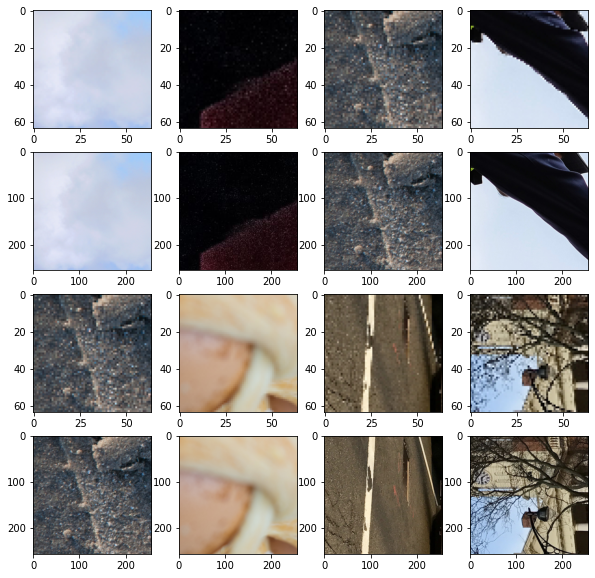

In [17]:
test_dataset = AugDataset._generator(8)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
s = time.time()
for idx in range(8):
    lr, hr = next(test_dataset)
    print('Time to load batch:', time.time() - s)
    ai, aj = idx // 4, idx % 4
    axes[2*ai][aj].imshow(lr[0]/2+0.5)
    axes[2*ai+1][aj].imshow(hr[0]/2+0.5)
    s = time.time()
plt.show()

### Layers

In [18]:
s_lrelu = lambda x: LeakyReLU(alpha=0.2)(x) * np.sqrt(2 / (1 + 0.2**2))
#xavier = tf.keras.initializers.VarianceScaling()
xavier = None
zeros = tf.keras.initializers.Zeros()

class ResAdd(Layer):
    def __init__(self):
        super().__init__()
        #self.res_gain = self.add_weight(shape=(), initializer=zeros, trainable=True)
        self.res_gain = tf.Variable(0., trainable=True)
    
    def call(self, inputs):
        res, skip = inputs
        rsqrt_res_gain = 1 / tf.math.sqrt(1 + self.res_gain ** 2)
        out = rsqrt_res_gain * (self.res_gain * res + skip)
        return out
    
class RBC(Layer):
    def __init__(self, nf, cardinality=4, squeeze_factor=0.5, use_se=False, se_factor=1.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        bottleneck_nf = nf
        hidden_nf = int(squeeze_factor * nf)

        if use_se:
            self.se = SE(bottleneck_nf, se_factor)

        self.squeeze_conv = Conv2D(hidden_nf, 1, kernel_initializer=xavier, use_bias=False, padding='same')
        self.cv1s = [Conv2D(hidden_nf, 3, kernel_initializer=xavier, padding='same') for _ in range(cardinality)]
        self.cv2s = [Conv2D(hidden_nf, 3, kernel_initializer=xavier, padding='same') for _ in range(cardinality)]
        self.unsqueeze_conv = Conv2D(bottleneck_nf, 1, kernel_initializer=xavier, use_bias=False, padding='same')
        self.squeeze_factor = squeeze_factor
        self.cardinality = cardinality
        self.use_se = use_se
        self.se_factor = se_factor
        self.nf = nf
    
    def call(self, inputs):
        branches = []
        x = inputs
        x = s_lrelu(x)
        x = self.squeeze_conv(x)
        x = s_lrelu(x)
        squeezed = x
        
        for branch in range(self.cardinality):
            x = self.cv1s[branch](squeezed)
            x = s_lrelu(x)
            x = self.cv2s[branch](x)
            x = s_lrelu(x)
            branches.append(x)
        
        if self.cardinality > 1:
            x = Concatenate()(branches) #* (1 / np.sqrt(self.cardinality))
        
        x = self.unsqueeze_conv(x)
        
        if self.use_se:
            x = self.se(x)

        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'nf': self.nf,
            'squeze_factor': self.squeeze_factor,
            'cardinality': self.cardinality,
            'use_se': self.use_se,
            'se_factor': self.se_factor,
        })
        return config

class SE(Layer):
    def __init__(self, fc_units, squeeze_factor=1.0):
        super().__init__()
        self.fc_units = fc_units
        self.squeeze_factor = squeeze_factor
        squeeze_nf = int(squeeze_factor * fc_units)
        self.gp = GlobalAveragePooling2D()
        self.fc1 = Dense(squeeze_nf, activation='relu')
        self.fc2 = Dense(fc_units, activation='sigmoid')
    
    def call(self, inputs):
        x = inputs
        x = self.gp(x)
        x = self.fc1(x)
        x = 2 * self.fc2(x)
        return inputs * x[:, np.newaxis, np.newaxis, :]
    
    def get_config(self):
        config = super().get_config()
        config['fc_units'] = self.fc_units
        config['squeeze_factor'] = self.squeeze_factor
        return config

class UpscaleBlock(Layer):
    def __init__(self, nf, use_se=False, se_factor=1.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.cv = Conv2D(nf, 3, kernel_initializer=xavier, padding='same')
        if use_se:
            self.se = SE(nf, squeeze_factor=se_factor)
        self.se_factor = se_factor
        self.use_se = use_se
        self.nf = nf
    
    def call(self, inputs):
        x = inputs
        x = self.cv(x)
        x = s_lrelu(x)
        if self.use_se:
            x = self.se(x)
        x = tf.nn.depth_to_space(x, block_size=2)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'se_factor': self.se_factor,
            'use_se': self.use_se,
            'nf': nf,
        })
        return config

# ESRGAN layers
class DB(Layer):
    def __init__(self, nf, squeeze_factor=0.5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        squeeze_nf = int(squeeze_factor * nf)
        self.cvs = [Conv2D(squeeze_nf, 3, kernel_initializer=xavier, padding='same') for _ in range(4)]
        self.last_cv = Conv2D(nf, 3, kernel_initializer=xavier, padding='same')
        self.res_add = ResAdd()
        self.nf = nf
        self.squeeze_factor = squeeze_factor

    def call(self, inputs):
        x = inputs
        past_inputs = [x]
        for i, block in enumerate(self.cvs):
            x_concat = Concatenate()(past_inputs) if i > 0 else x
            x = s_lrelu(block(x_concat))
            past_inputs.append(x)
        x_concat = Concatenate()(past_inputs)
        x = s_lrelu(self.last_cv(x_concat))
        return x
    
    def get_config(self):
        cfg = super().get_config()
        cfg['nf'] = self.nf
        cfg['squeeze_factor'] = self.squeeze_factor
        return cfg

class RRDB(Layer):
    def __init__(self, nf, squeeze_factor=0.5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dbs = [DB(nf, squeeze_factor) for _ in range(3)]

    def call(self, inputs):
        x = inputs
        for i, block in enumerate(self.dbs):
            skip = x
            x = block(x)
            x = skip + 0.2 * x
        x = inputs + 0.2 * x
        return x
    
    def get_config(self):
        cfg = super().get_config()
        cfg['nf'] = self.nf
        cfg['squeeze_factor'] = self.squeeze_factor
        return cfg

### Generator Arch

Transformer

In [19]:
# Encodes an image into a single feature map using a transformer
class Encoder(Layer):
    def __init__(self, nheads=4, nblocks=4, nf=64, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.nheads = nheads
        self.nblocks = nblocks
        self.nf = nf
        self.initial_project = Dense(nf, kernel_initializer=xavier, use_bias=False)
        self.final_project = Dense(1, kernel_initializer=xavier, activation='sigmoid')
        
        self.embeddings = tf.Variable(
            initial_value=tf.keras.initializers.RandomNormal()(shape=(256, nf)),
            trainable=True)
        
        self.lns = [LayerNormalization() for _ in range(nblocks)]
        self.mhas = [MultiHeadAttention(nheads, nf//nheads) for _ in range(nblocks)]
        
        # feed-forward network blocks
        self.ffns = [Sequential([
            LayerNormalization(),
            Dense(4*nf, activation='relu', kernel_initializer=xavier),
            Dense(nf, kernel_initializer=xavier)
        ]) for _ in range(nblocks)]
    
    def call(self, x):
        N = tf.shape(x)[0]
        H = tf.shape(x)[1]
        W = tf.shape(x)[2]
        C = x.shape[-1]
        x = tf.image.resize(x, (16, 16)) # image worth 16x16 words, no?
        x = tf.reshape(x, (N, 256, C))
        x = self.initial_project(x) # (256, C) -> (256, nf)
        x += tf.cast(self.embeddings, x.dtype)
        
        for ln, mha, ffn in zip(self.lns, self.mhas, self.ffns):
            skip = x
            x = ln(x)
            x = mha(x, x)
            x = x + skip

            skip = x
            x = ffn(x)
            x = x + skip

        x = self.final_project(x) # (256, nf) -> (256, 1)
        x = tf.reshape(x, (N, 16, 16, 1)) # (256, 1) -> (16, 16, 1)
        x = tf.image.resize(x, (H, W)) # (16, 16, 1) -> (H, W, 1)
        return x
    
    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            'nheads': self.nheads,
            'nblocks': self.nblocks,
            'nf': self.nf
        })
        
        return cfg

Full architecture

In [20]:
def gen_gen(n_blocks=CNN_NBLOCKS, n_up_blocks=2, nf=CNN_NF):
    inp = Input((None, None, 3))
                
    if USE_TF:
        encoder = Encoder(NHEADS, TF_NBLOCKS, TF_NF)
    
    first_conv = Conv2D(nf, 1, kernel_initializer=xavier, padding='same')(inp)
    x = first_conv
    attention_fmaps = []
    for _ in range(n_blocks):
        #x = RB(nf)(x)
        x = RBC(nf, CARDINALITY, use_se=USE_SE, se_factor=SE_FACTOR)(x)
        
        if USE_TF:
            attention_fmap = encoder(x)
            x *= tf.cast(attention_fmap, x.dtype)
        
    last_conv = Conv2D(nf, 3, kernel_initializer=xavier, padding='same')(x)
    x = ResAdd()([last_conv, first_conv])
    
    for block_idx in range(n_up_blocks):
        num_f = max(nf // (4 ** (block_idx + 1)), 4)
        #x = UpscaleBlock(num_f)(x)
        x = PixelShuffle(nf, use_se=USE_SE, se_factor=SE_FACTOR)(x)
        #num_f = nf // (4 ** (block_idx))
        #x = UpscaleBlockMini(num_f)(x)
    
    x = Conv2D(3, 3, padding='same')(x)
    x = tf.cast(x, 'float32')
    
    return Model(inp, x, name='generator')

def gen_gen(n_blocks=CNN_NBLOCKS, nf=NF, use_tf=True, n_up_blocks=2):
    inp = Input((None, None, 3))
                
    if use_tf:
        encoder = Encoder(NHEADS, TF_NBLOCKS, nf)
    
    first_conv = Conv2D(nf, 3, kernel_initializer=xavier, padding='same')(inp)
    x = first_conv
    attention_fmaps = []
    for _ in range(n_blocks):
        skip = x
        x = RBC(nf, CARDINALITY, use_se=USE_SE, se_factor=SE_FACTOR)(x)
        
        if use_tf:
            attention_fmap = Conv2D(nf, 1, padding='same')(encoder(x))
            x = x / tf.math.reduce_std(x, axis=[1, 2], keepdims=True)
            x *= tf.cast(attention_fmap, x.dtype)

        x = ResAdd()([x, skip])
        
    last_conv = Conv2D(nf, 3, kernel_initializer=xavier, padding='same')(x)
    x = ResAdd()([last_conv, first_conv])
    
    for block_idx in range(n_up_blocks):
        x = UpscaleBlock(nf, use_se=USE_SE, se_factor=SE_FACTOR)(x)
    
    x = Conv2D(3, 3, padding='same')(x)
    x = tf.cast(x, 'float32')
    
    return Model(inp, x, name='generator')

### Discriminator Arch

In [21]:
def gen_disc(nf=int(32*PARAM_MULT), n_layers_shrink=3):
    dcvs = []
    ucvs = []
    extras = []
    
    inp = Input((HR_RES, HR_RES, 3))
    x = Conv2D(nf, 3, kernel_initializer=xavier, padding='same')(inp)
    dcvs.append(x)
    
    # down
    for i in range(n_layers_shrink):
        channel_multiplier = 2 ** (i + 1)
        x = Conv2D(min(256, nf * channel_multiplier), 3, kernel_initializer=xavier, strides=2, padding='same')(x)
        x = s_lrelu(x)
        dcvs.append(x)
        
    # up
    for i in range(n_layers_shrink):
        channel_multiplier = 2 ** (n_layers_shrink - i - 1)
        x = UpscaleBlock(min(256, nf * channel_multiplier))(x)
        x = s_lrelu(x)
        x = ResAdd()([x, dcvs[-i - 2]])
    last_upconv = x
    
    x = Conv2D(nf, 3, kernel_initializer=xavier, padding='same')(x)
    x = s_lrelu(x)
    x = ResAdd()([x, last_upconv])
    
    x = Conv2D(1, 1, kernel_initializer=xavier, padding='same')(x)
    x = tf.cast(x, 'float32')
    
    return Model(inp, x, name='discriminator')

### VGG Feature Extractor Arch

In [22]:
vgg_layer_idxs = [2, 5, 10, 15, 20] # corresponds to conv_1_2, conv_2_2, conv_3_4, conv_4_4, conv_5_4

def gen_vgg_extractor():
    vgg = kapp.VGG19(
        include_top=False,
        input_shape=(HR_RES, HR_RES, 3)
    )
    
    outputs = []
    
    for layer_idx in vgg_layer_idxs:
        # get info from the layer's parameters
        layer_kernel = K.get_value(vgg.layers[layer_idx].kernel)
        layer_bias = K.get_value(vgg.layers[layer_idx].bias)
        layer_output_fmaps = layer_kernel.shape[-1] # o in kkio
        layer_output_kernel_shape = layer_kernel.shape[0] # k in kkio
        
        # create a deep copy of the layer which we want to extract, but specify no activation
        extracted_layer = Conv2D(layer_output_fmaps, layer_output_kernel_shape, padding='same', activation='linear')
        extracted_layer(vgg.layers[layer_idx-1].output) # build the kernel so it doesn't get reinitialized witih random values during build time
        K.set_value(extracted_layer.kernel, layer_kernel)
        K.set_value(extracted_layer.bias, layer_bias)
        outputs.append(tf.cast(extracted_layer(vgg.layers[layer_idx-1].output), 'float32'))
    
    vgg_extractor = Model(vgg.input, outputs, name='vgg_extractor')
    vgg_extractor.trainable = False
    
    return vgg_extractor

Find Optimal LR

MAE: 0.4801


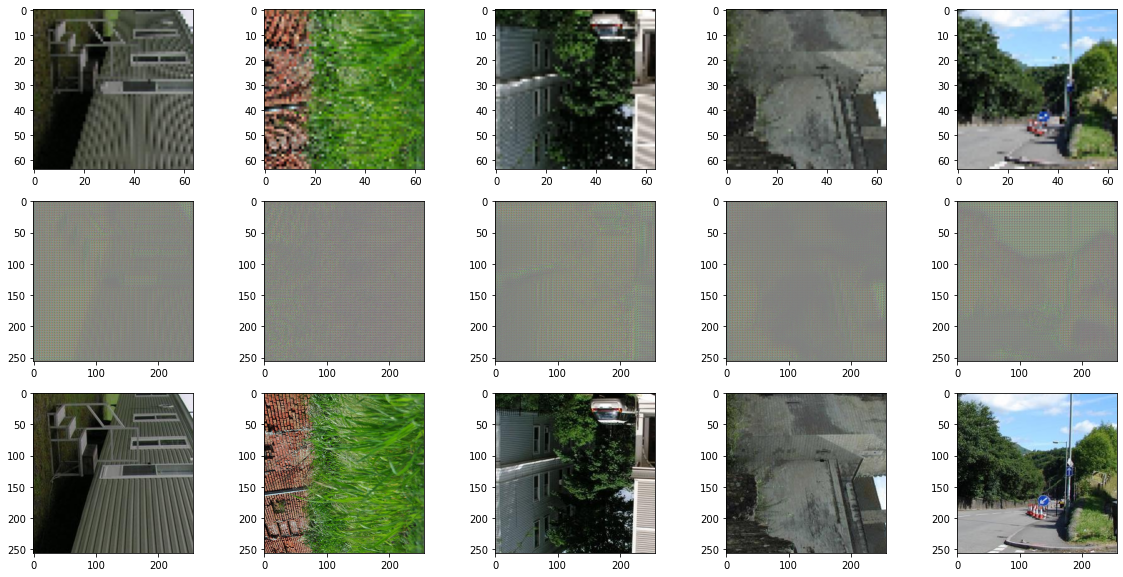

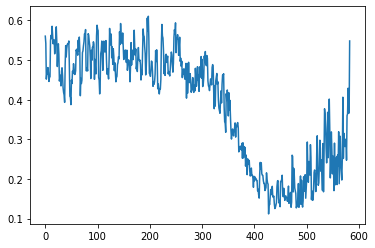

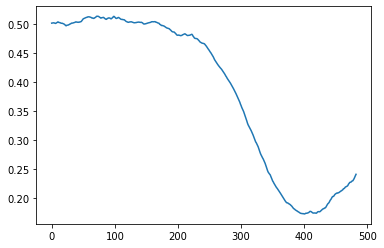

Optimal learning rate: 0.0031622776601683347


In [23]:
if tpuOn:
    with strategy.scope():
        gen = gen_gen()
else:
    gen = gen_gen()
gen_opt = SGD(lr=1e-5, momentum=0.9, nesterov=True)
mae = lambda y_true, y_pred: tf.math.reduce_mean(tf.math.abs(y_pred - y_true))
display()

@tf.function
def psnr_step(lr, hr):
    sr = gen(lr)
    loss = mae(usm(hr), sr)
    grads = tf.gradients(loss, gen.trainable_variables)
    gen_opt.apply_gradients(zip(grads, gen.trainable_variables))
    return loss

def lr_find(min_lr=1e-6, steps_per_mag=100):
    losses = []
    best_loss = 999
    loss = 999
    start = time.time()
    cost = 0
    alpha = min_lr
    lr_scale = 10 ** (1 / steps_per_mag) # lr_scale ^ steps_per_mag = 10 -> lr_scale = 10 ^ (1 / steps_per_mag)
    if tpuOn:
        steps_per_mag = steps_per_mag // 8
        while best_loss * 4 > loss:
            lr, hr = next(dataset)
            loss = tf.reduce_mean(strategy.run(psnr_step, args=(lr, hr)).values).numpy()
            best_loss = min(best_loss, loss)
            losses.append(loss)
            alpha *= lr_scale
            K.set_value(gen_opt.learning_rate, alpha)
    else:
        for lr, hr in dataset:
            if best_loss * 4 < loss:
                break
            loss = psnr_step(lr, hr).numpy()
            #print(loss)
            best_loss = min(best_loss, loss)
            losses.append(loss)
            alpha *= lr_scale
            K.set_value(gen_opt.learning_rate, alpha)
    
    losses = np.array(losses)
    lr_step = np.arange(losses.shape[0])
    plt.plot(lr_step, losses)
    plt.show()
    
    sma = np.array([np.mean(losses[i:i+steps_per_mag]) for i in range(losses.shape[0] - steps_per_mag)])
    diff_X = np.arange(sma.shape[0])
    plt.plot(diff_X, sma)
    plt.show()
    
    best_lr = min_lr * (lr_scale ** (np.argmin(sma) + steps_per_mag/2)) / 10
    print('Optimal learning rate:', best_lr)
    
    return best_lr, losses

lr, _losses = lr_find()

### Builld models

In [26]:
if train_mode != 'psnr':
    lr = lr / 2

if tpuOn:
    with strategy.scope():
        gen = gen_gen()
        #disc = gen_disc(nf=128, n_layers_shrink=3)
        vgg = gen_vgg_extractor()
else:
    gen = gen_gen()
    #disc = gen_disc(nf=128, n_layers_shrink=3)
    vgg = gen_vgg_extractor()
    
gen_opt = SGD(lr=lr, momentum=0.95, nesterov=True)
disc_opt = SGD(lr=lr, momentum=0.95, nesterov=True)

model_path = os.path.join('/kaggle/input/models/heavySR', 'scale{}'.format(PARAM_MULT))
if pretrained_net:
    gen.load_weights(os.path.join(model_path, 'genWeights.h5'))
if pretrained_gan:
    disc.load_weights(os.path.join(model_path, 'discWeights.h5'))

mae = lambda y_true, y_pred: tf.math.reduce_mean(tf.math.abs(y_pred - y_true))

Generator summary

In [27]:
if True:
    print(gen.summary())

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, None, None, 6 1792        input_6[0][0]                    
__________________________________________________________________________________________________
rbc_24 (RBC)                    (None, None, None, 6 30912       conv2d_145[0][0]                 
__________________________________________________________________________________________________
encoder_3 (Encoder)             (None, None, None, 1 816385      input_6[0][0]                    
__________________________________________________________________________________________

Discriminator summary

In [28]:
if False:
    print(disc.summary())

VGG extractor summary

In [29]:
if False:
    print(vgg.summary())

### PSNR step and training loop

Step func

In [30]:
@tf.function
def psnr_step(lr, hr):
    sr = gen(lr)
    loss = mae(usm(hr), sr)
    grads = tf.gradients(loss, gen.trainable_variables)
    gen_opt.apply_gradients(zip(grads, gen.trainable_variables))
    return loss

Train func

In [31]:
best_cost = None

def psnr_train(epochs=1):
    global NET_STEPS, best_cost
    
    total_cost = 0
    for epoch in range(epochs):
        start = time.time()
        cost = 0
        if tpuOn:
            for step_num in range(STEPS_PER_EPOCH):
                lr, hr = next(dataset)
                loss = tf.reduce_mean(strategy.run(psnr_step, args=(lr, hr)).values).numpy()
                cost += loss
        else:
            for lr, hr in dataset:
                loss = psnr_step(lr, hr).numpy()
                cost += loss
            
        end = time.time()
        duration = round(end - start)
        total_cost += cost
        print('Epoch: {} | Cost: {} | Time to Complete: {}m {}s'.format(epoch, r4(cost), duration // 60, duration % 60))
    
    if best_cost is None or np.abs((total_cost - best_cost) / best_cost) < 0.5:
        best_cost = total_cost
        save_models(askInp=False)

One Cycle Train

In [32]:
def oc_train(num_steps=int(10*STEPS_PER_EPOCH)):
    alpha = lr
    mm = 0.95
    alpha_step = 0.9 * alpha / (num_steps * 0.4)
    mm_step = 0.1 / (num_steps * 0.4)
    alpha /= 10
    K.set_value(gen_opt.learning_rate, alpha)
    start = time.time()
    cost = 0
    losses = []
    if tpuOn:
        for step_num in range(num_steps):
            lr_batch, hr_batch = next(dataset)
            loss = tf.reduce_mean(strategy.run(psnr_step, args=(lr_batch, hr_batch)).values).numpy()
            losses.append(loss)
            if step_num == int(0.4 * num_steps):
                alpha_step *= -1
                mm_step *= -1
            if step_num == int(0.8 * num_steps):
                num_steps_left = num_steps - step_num 
                alpha_step = -alpha / num_steps_left 
                mm_step = 0
            
            alpha += alpha_step
            mm -= mm_step
            K.set_value(gen_opt.learning_rate, max(alpha, 1e-8))
            K.set_value(gen_opt.momentum, mm)
            cost += loss
    else:
        step_num = 0
        for lr_batch, hr_batch in dataset:
            if step_num >= num_steps:
                break
            loss = psnr_step(lr_batch, hr_batch).numpy()
            losses.append(loss)
            if step_num == int(0.4 * num_steps):
                alpha_step *= -1
                mm_step *= -1
            if step_num == int(0.8 * num_steps):
                num_steps_left = num_steps - step_num 
                alpha_step = -alpha / num_steps_left 
                mm_step = 0
            
            alpha += alpha_step
            mm -= mm_step
            K.set_value(gen_opt.learning_rate, max(alpha, 1e-8))
            K.set_value(gen_opt.momentum, mm)
            cost += loss
            step_num += 1

    end = time.time()
    duration = round(end - start)
    print('Cost: {} | Time to Complete: {}m {}s'.format(r4(cost), duration // 60, duration % 60))
    plt.plot(np.arange(len(losses)), losses)
    plt.show()
    [print(loss) for loss in losses]

### GAN step and training loop

Loss funcs

In [33]:
@tf.function
def dra(observed_preds, base_preds):
    return tf.math.sigmoid(observed_preds - tf.reduce_mean(base_preds))

@tf.function
def disc_loss_fn(true_preds, fake_preds):
    true_loss = -tf.reduce_mean(tf.math.log(dra(true_preds, fake_preds) + EPS))
    fake_loss = -tf.reduce_mean(tf.math.log(1 - dra(fake_preds, true_preds) + EPS))
    return true_loss + fake_loss

@tf.function
def gen_loss_fn(hr, sr, true_preds, fake_preds, vgg_weight=1e-1, adv_weight=1e-2, pixel_weight=1.0):
    s = lambda x: x / 12.75 # scale
    # VGG loss
    hr12, hr22, hr34, hr44, hr54 = vgg(hr)
    sr12, sr22, sr34, sr44, sr54 = vgg(sr)
    vgg_loss = 0.1 * mae(s(hr12), s(sr12)) + 0.1 * mae(s(hr22), s(sr22)) + mae(s(hr34), s(sr34)) + mae(s(hr44), s(sr44)) + mae(s(hr54), s(sr54))
    vgg_loss *= vgg_weight
    
    # Adversarial loss
    adv_loss = adv_weight * -tf.reduce_mean(tf.math.log(dra(fake_preds, true_preds) + EPS))
    
    # Pixelwise loss
    #pixel_loss = pixel_weight * (mae(hr, sr) + ps_loss(sr) / 20)
    pixel_loss = pixel_weight * mae(hr, sr)
    
    return vgg_loss, adv_loss, pixel_loss

Step func

In [34]:
@tf.function
def gan_step(lr, hr):
    sr = gen(lr)
    hr = usm(hr)
    true_preds = disc(hr)
    fake_preds = disc(sr)

    disc_loss = disc_loss_fn(true_preds, fake_preds)
    vgg_loss, adv_loss, pixel_loss = gen_loss_fn(hr, sr, true_preds, fake_preds)
    gen_loss = vgg_loss + adv_loss + pixel_loss

    g_grad = tf.gradients(gen_loss, gen.trainable_variables)
    gen_opt.apply_gradients(zip(g_grad, gen.trainable_variables))
    d_grad = tf.gradients(disc_loss, disc.trainable_variables)
    disc_opt.apply_gradients(zip(d_grad, disc.trainable_variables))

    return disc_loss, vgg_loss, adv_loss, pixel_loss #, true_preds, fake_preds

Train func

In [35]:
def gan_train(epochs=1, steps_per_epoch=50):
    global GAN_STEPS
    
    for epoch in range(epochs):
        start = time.time()
        dcost, vgg_cost, adv_cost, pixel_cost = 0, 0, 0, 0
        if tpuOn:
            for step_num in range(STEPS_PER_EPOCH):
                lr, hr = next(dataset)
                dloss, vgg_loss, adv_loss, pixel_loss = toNp(*strategy.run(gan_step, args=(lr, hr)))
                dcost += dloss
                vgg_cost += vgg_loss
                adv_cost += adv_loss
                pixel_cost += pixel_loss
        else:
            for lr, hr in dataset:
                dloss, vgg_loss, adv_loss, pixel_loss = gan_step(lr, hr)
                dcost += dloss
                vgg_cost += vgg_loss
                adv_cost += adv_loss
                pixel_cost += pixel_loss
                
            GAN_STEPS -= 1
        end = time.time()
        duration = round(end - start)
        print('Epoch: {} | VGG Cost: {} | Adversarial Cost: {} | Pixel Cost: {}'.format(epoch, r4(vgg_cost), r4(adv_cost), r4(pixel_cost)), end=' | ')
        print('Discriminator Cost: {} | Time to Complete: {}m {}s'.format(r4(dcost), duration // 60, duration % 60))
    
    save_models(askInp=False)

### Train

Cost: 1342.791 | Time to Complete: 75m 16s


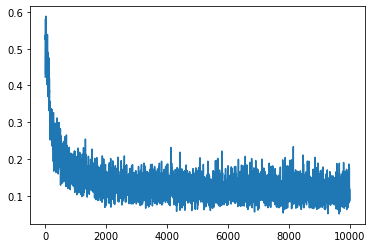

0.4230747
0.4364061
0.50948316
0.52117485
0.49861106
0.500941
0.5374494
0.5235384
0.5805795
0.5187213
0.4898275
0.43179104
0.44128942
0.43277907
0.50918096
0.55384976
0.5598383
0.57575893
0.5880486
0.5801541
0.5820382
0.57878226
0.5389941
0.44944632
0.4577771
0.46372327
0.4893156
0.49590364
0.49659523
0.49144948
0.47974232
0.4338306
0.4262115
0.4351685
0.47355565
0.445369
0.46185562
0.4857858
0.4918131
0.48359382
0.46740755
0.49733952
0.4430406
0.43898627
0.44327378
0.4277297
0.4453253
0.51906216
0.48920134
0.48976755
0.4872656
0.5067826
0.46980956
0.5136099
0.49014398
0.452993
0.44953153
0.47196445
0.43730286
0.42491925
0.41891715
0.4633007
0.40376833
0.4239148
0.42798948
0.40272042
0.513789
0.51666874
0.51581883
0.5190871
0.53843385
0.51099783
0.49961856
0.49303114
0.4679614
0.46881437
0.45272347
0.43258646
0.490419
0.46958426
0.4736689
0.45819393
0.46287742
0.43070638
0.4323857
0.42152286
0.39469314
0.37433195
0.37060738
0.3697656
0.3864938
0.4320198
0.4376018
0.4461129
0.45558643
0

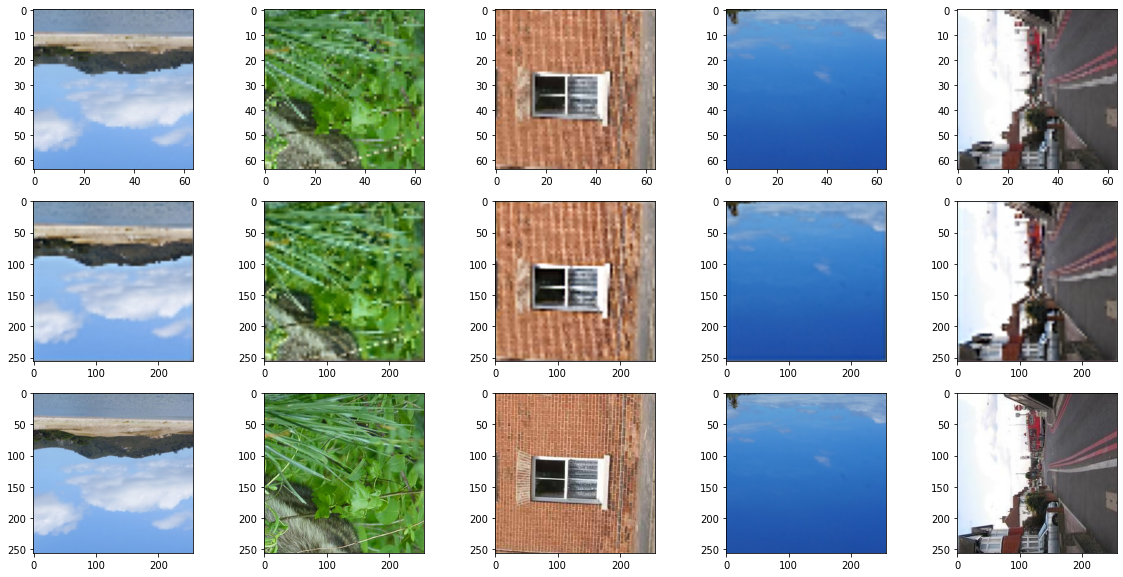

"while True:\n    display()\n    if train_mode != 'gan':\n        print('Training in PSNR mode.')\n        psnr_train(epochs=1000)\n    else:\n        print('Training in GAN mode.')\n        gan_train(epochs=10)"

In [36]:
# save_models(askInp=False)

oc_train()
display()
'''while True:
    display()
    if train_mode != 'gan':
        print('Training in PSNR mode.')
        psnr_train(epochs=1000)
    else:
        print('Training in GAN mode.')
        gan_train(epochs=10)'''

### Save models

MAE: 0.0998


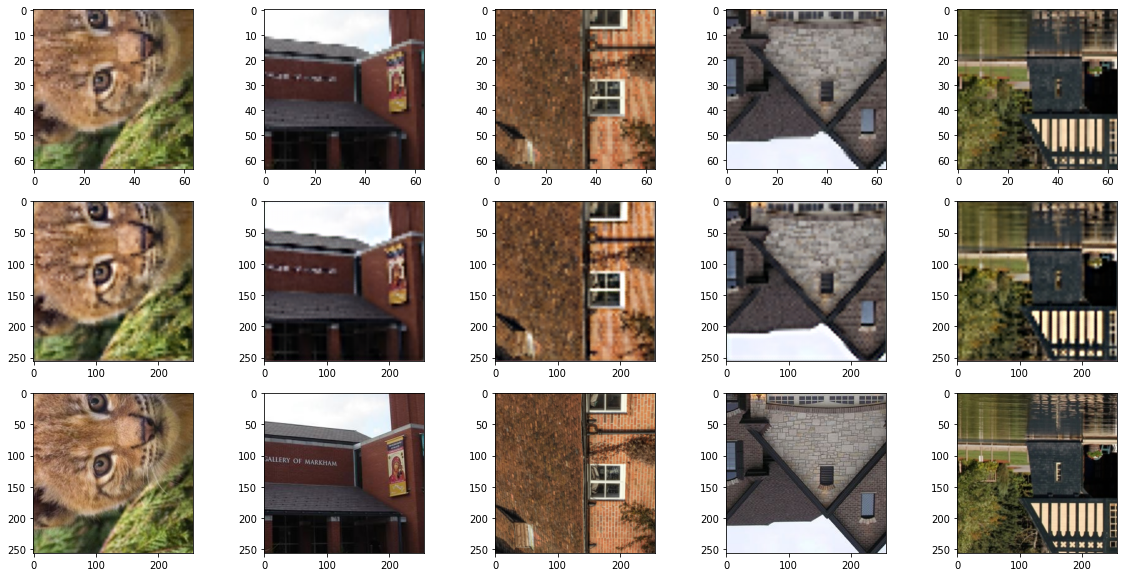

NameError: name 'disc' is not defined

In [37]:
display()
save_models(askInp=False)